# BQSKit Compilation with Error Mitigation

In this tutorial we will describe how to use error mitigation capabilities from [Mitiq](https://mitiq.readthedocs.io/en/stable/), together with the compilation capabilities of [BQSKit](https://bqskit.lbl.gov/).

Before getting started, run the following install commands to ensure you have the required python packages.

- `pip install mitiq`
- `pip install bqskit==0.3.0` (here we use an older version of `bqskit` in order to satisfy version requirements between the two packages)

The main steps taken in this tutorial are:

1. Generate a random circuit
2. Compile it with `bqskit`
3. Use error mitigation on the compiled circuit
4. Compare the results obtained with and without error mitigation

---

To begin we import many of the required functions.


In [1]:
import cirq
import numpy as np
import ucc

import mitiq

## Random circuit generation

To begin, we use `cirq`'s [`random_circuit`](https://quantumai.google/reference/python/cirq/testing/random_circuit) function to generare a random circuit with specified qubit number, depth and density (which refers to the probability of an operation occuring at a given moment).
Here we also use a random seed for reproducibility.


In [3]:
num_qubits = 3
depth = 10
density = 1
RANDOM_SEED = 479

random_circuit = cirq.testing.random_circuit(
    num_qubits, depth, density, random_state=RANDOM_SEED
)

print(random_circuit)

                                          ┌──┐
0: ───X───Z───Y───X───────────────iSwap─────@────H───Y───
                  │               │         │
1: ───S───X───────@───Y───iSwap───┼────────S┼────X───X───
          │               │       │         │
2: ───────@───S───Y───Y───iSwap───iSwap─────@────────────
                                          └──┘


## Compilation

The temporary file can then be read in by `bqskit`, and compiled.
By default `bqskit` attempts to reduce the circuit depth as its primary optimization, and compiles into the following gateset: $\{\mathsf{U3}, \mathsf{CNOT}, \sqrt{X}, R_Z\}$.


In [4]:
compiled_circuit = ucc.compile(random_circuit)

print(compiled_circuit)

q_0: ───Ry(0.5π)─────Rz(-0.755π)─────────────────────────────────────────────────────────────────────@───────────Rz(0.755π)───Ry(-0.5π)─────Ry(-0.5π)────Rz(0.5π)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@───Rz(-0.5π)─────Ry(0.5π)─────Rz(-0.5π)─────@───Rz(-0.5π)─────Ry(-0.5π)─────────────────@───Ry(0.5π)───Rz(-0.5π)────
                                                                                                     │                                                                                                                                                                                        │                                            │                                           │
q_1: ───Rz(-0.5π)────Ry(0.5π)──────Rz(0.5π)───@───Rz(0.5π)────Ry(0.5π)─────Rz(0.032π)───Ry(0.5π)─────X───────────Ry(0.5π)─────Rz(-0.968π)───Rz(-0.75π)───Ry(0.5π)───Rz(0.5π)───@───Rz(0.5π)──────Ry(0.5π)──────────────────

Since `bqskit` uses a custom intermediate representation, we need to now convert this circuit to a form we can use for futher processing, and error mitigation. This can be done easily by writing the circuit back to QASM, which `cirq` can then read in.


## Error Mitigation

Now that we have a compiled circuit, we are ready to use `mitiq`'s error mitigation capabilities.
In this tutorial we will use one of the simplest, and easiest to use methods: [Zero Noise Extrapolation](https://mitiq.readthedocs.io/en/stable/guide/zne-1-intro.html) (ZNE), but there are multiple other techniques described in our [user guide](https://mitiq.readthedocs.io/en/stable/guide/guide.html).

To use this method, we need to define a function which takes as input a circuit, and returns some sort of expectation value, or probability. Here we will define a function `execute` which adds a tunable noise parameter, which controls the strength of our assumed two-qubit depolarizing noise model. Then a density matrix simulation is run, and we measure the probability of observing the system in the ground state(s).


In [5]:
def execute(circuit, noise_level=0.05):
    noisy_circuit = cirq.Circuit()
    for op in circuit.all_operations():
        noisy_circuit.append(op)
        if len(op.qubits) == 2:
            noisy_circuit.append(
                cirq.depolarize(p=noise_level, n_qubits=2)(*op.qubits)
            )

    rho = (
        cirq.DensityMatrixSimulator()
        .simulate(noisy_circuit)
        .final_density_matrix
    )
    return rho[0, 0].real

Since we'd like to see how compilation effects error mitigation, we run the `execute` function on both the compiled, and random circuits, both with and without noise.


In [6]:
uncompiled_ideal_value = execute(random_circuit, noise_level=0.0)
uncompiled_noisy_value = execute(random_circuit)

compiled_ideal_value = execute(compiled_circuit, noise_level=0.0)
compiled_noisy_value = execute(compiled_circuit)

We can now use ZNE --- on both the random, and compiled circuit --- to obtain the mitigated expectation values for these circuits.


In [7]:
from mitiq import zne

uncompiled_mitigated_result = zne.execute_with_zne(random_circuit, execute)
compiled_mitigated_result = zne.execute_with_zne(compiled_circuit, execute)

## Comparison

These data are then summarized in the following output.


In [9]:
header = "{:<11} {:<15} {:<10}"
entry = "{:<11}  {:<15.2f} {:<10.2f}"
int_entry = "{:<11}  {:<15} {:<10}"
print(header.format("", "uncompiled", "compiled"))
print(entry.format("ideal", uncompiled_ideal_value, compiled_ideal_value))
print(entry.format("noisy", uncompiled_noisy_value, compiled_noisy_value))
print(
    entry.format(
        "mitigated", uncompiled_mitigated_result, compiled_mitigated_result
    )
)
print(
    entry.format(
        "error",
        abs(uncompiled_ideal_value - uncompiled_mitigated_result),
        abs(compiled_ideal_value - compiled_mitigated_result),
    )
)
print(
    int_entry.format(
        "depth",
        len(random_circuit),
        len(compiled_circuit),
    )
)

            uncompiled      compiled  
ideal        0.50            0.50      
noisy        0.43            0.41      
mitigated    0.48            0.45      
error        0.02            0.05      
depth        10              35        


Hence for this particular random circuit we see that using both compilation _and_ error mitigation combine for the most accurate result.
Note that despite using BQSKit to compile the circuit, the depth has actually increased.
This can occsionally happen when the random circuit contains gates that are harder to compile into BQSKit's default gateset.

We can now wrap this code into a loop to get a better understanding of how errors change for the following four combinations of compilation and mitigation:

| compiled | mitigated |
| -------- | --------- |
| ❌       | ❌        |
| ❌       | ✅        |
| ✅       | ❌        |
| ✅       | ✅        |


In [10]:
from tqdm import tqdm

num_circuits = 200
num_qubits = 4
depth = 40

ideal_uncompiled, ideal_compiled = [], []
mitigated_uncompiled, mitigated_compiled = [], []
unmitigated_uncompiled, unmitigated_compiled = [], []
depths = []

for i in tqdm(range(num_circuits)):
    random_circuit = cirq.testing.random_circuit(num_qubits, depth, 1)

    compiled_circuit = ucc.compile(random_circuit)

    depths.append((len(random_circuit), len(compiled_circuit)))

    ideal_uncompiled.append(execute(random_circuit, noise_level=0.0))
    ideal_compiled.append(execute(compiled_circuit, noise_level=0.0))

    unmitigated_uncompiled.append(execute(random_circuit))
    unmitigated_compiled.append(execute(compiled_circuit))

    mitigated_uncompiled.append(zne.execute_with_zne(random_circuit, execute))
    mitigated_compiled.append(zne.execute_with_zne(compiled_circuit, execute))

100%|██████████| 200/200 [05:51<00:00,  1.76s/it]


As a sanity check we ensure that the ideal values for the random circuit, and its compiled counterpart are equivalent up to $10^{-7}$.


In [11]:
np.allclose(ideal_uncompiled, ideal_compiled, atol=1e-7)

False

To see how compilation, and mitigation effect the overall accuracy of the measured observables, we calculate the errors.


In [12]:
uncompiled_error, compiled_error = [], []
uncompiled_unmitigated_error, compiled_unmitigated_error = [], []

for ideal, uncompiled, compiled, noisy_uncompiled, noisy_compiled in zip(
    ideal_uncompiled,
    mitigated_uncompiled,
    mitigated_compiled,
    unmitigated_uncompiled,
    unmitigated_compiled,
):
    uncompiled_error.append(abs(ideal - uncompiled))
    compiled_error.append(abs(ideal - compiled))
    uncompiled_unmitigated_error.append(abs(ideal - noisy_uncompiled))
    compiled_unmitigated_error.append(abs(ideal - noisy_compiled))

We can now histogram the errors to get a visual representation of the effect of these two operations.


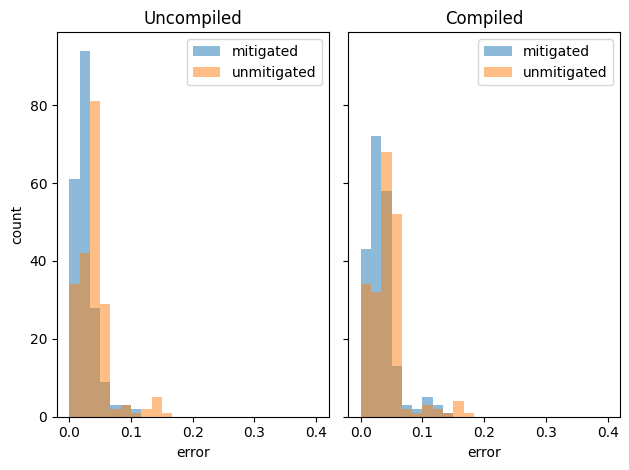

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, tight_layout=True)
bins = np.linspace(0, 0.4, 25)

axs[0].hist(uncompiled_error, bins=bins, label="mitigated", alpha=0.5)
axs[0].hist(
    uncompiled_unmitigated_error, bins=bins, label="unmitigated", alpha=0.5
)

axs[1].hist(compiled_error, bins=bins, label="mitigated", alpha=0.5)
axs[1].hist(
    compiled_unmitigated_error, bins=bins, label="unmitigated", alpha=0.5
)

axs[0].set_xlabel("error")
axs[1].set_xlabel("error")
axs[0].set_ylabel("count")


axs[0].set_title("Uncompiled")
axs[1].set_title("Compiled")

axs[0].legend()
axs[1].legend();

The plot above shows that error mitigation helps in both cases: with uncompiled circuits and with compiled circuits.
In fact, the mean of both histograms decreases when using error mitigation.


In [ ]:
round(
    np.array(compiled_unmitigated_error).mean()
    - np.array(compiled_error).mean(),
    4,
)

0.0137

In [ ]:
round(
    np.array(compiled_unmitigated_error).std()
    - np.array(compiled_error).std(),
    4,
)

0.0101

In this tutorial we've seen how one can use error mitigation in conjunction with circuit compilation.
For more information check out the [`bqskit`](https://bqskit.readthedocs.io/en/latest/) and [`mitiq`](https://mitiq.readthedocs.io/en/stable/) documentation.


In [ ]:
import cirq
import ucc

from mitiq import zne


def execute(circuit, noise_level=0.05):
    """depolarizing noise after each 2-qubit gate, returning the probability
    that the system is in the ground state"""

    noisy_circuit = cirq.Circuit()
    for op in circuit.all_operations():
        noisy_circuit.append(op)
        if len(op.qubits) == 2:
            noisy_circuit.append(
                cirq.depolarize(p=noise_level, n_qubits=2)(*op.qubits)
            )

    rho = (
        cirq.DensityMatrixSimulator()
        .simulate(noisy_circuit)
        .final_density_matrix
    )
    return rho[0, 0].real


def get_circuit(depth: int) -> cirq.Circuit:
    num_qubits = 3
    density = 1
    random_circuit = cirq.testing.random_circuit(
        num_qubits,
        depth,
        density,
        gate_domain={cirq.X: 1, cirq.Y: 1, cirq.Z: 1, cirq.H: 1, cirq.CNOT: 2},
        random_state=439,
    )
    return random_circuit


data = []

for depth in range(20, 90, 5):
    for _ in range(10):
        uncompiled_circuit = get_circuit(depth)
        compiled_circuit = ucc.compile(
            uncompiled_circuit,
        )
        ideal = execute(uncompiled_circuit, noise_level=0.0)

        uncompiled_unmitigated = execute(uncompiled_circuit)
        compiled_unmitigated = execute(compiled_circuit)
        mitigated_uncompiled = zne.execute_with_zne(
            uncompiled_circuit, execute
        )
        mitigated_compiled = zne.execute_with_zne(compiled_circuit, execute)

        if abs(ideal) < 1e-7:
            continue

        uncompiled_mitigated_error = abs(ideal - mitigated_uncompiled) / abs(
            ideal
        )
        compiled_mitigated_error = abs(ideal - mitigated_compiled) / abs(ideal)
        uncompiled_unmitigated_error = abs(
            ideal - uncompiled_unmitigated
        ) / abs(ideal)
        compiled_unmitigated_error = abs(ideal - compiled_unmitigated) / abs(
            ideal
        )
        data.append(
            {
                "depth": depth,
                "compiled_depth": len(compiled_circuit),
                "uncompiled_unmitigated_error": uncompiled_unmitigated_error,
                "uncompiled_mitigated_error": uncompiled_mitigated_error,
                "compiled_unmitigated_error": compiled_unmitigated_error,
                "compiled_mitigated_error": compiled_mitigated_error,
            }
        )

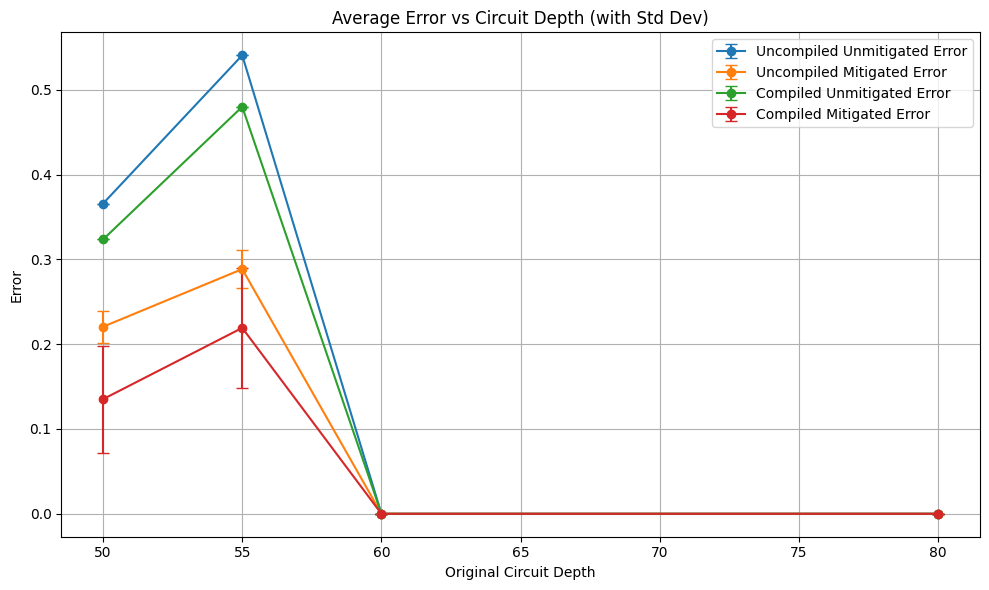

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(data)

grouped = df.groupby("depth").agg(["mean", "std"])

# Plot
plt.figure(figsize=(10, 6))

error_types = [
    "uncompiled_unmitigated_error",
    "uncompiled_mitigated_error",
    "compiled_unmitigated_error",
    "compiled_mitigated_error",
]

for error in error_types:
    means = grouped[error]["mean"]
    stds = grouped[error]["std"]
    plt.errorbar(
        grouped.index,
        means,
        yerr=stds,
        label=error.replace("_", " ").title(),
        marker="o",
        capsize=4,
    )

plt.xlabel("Original Circuit Depth")
plt.ylabel("Error")
plt.title("Average Error vs Circuit Depth (with Std Dev)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

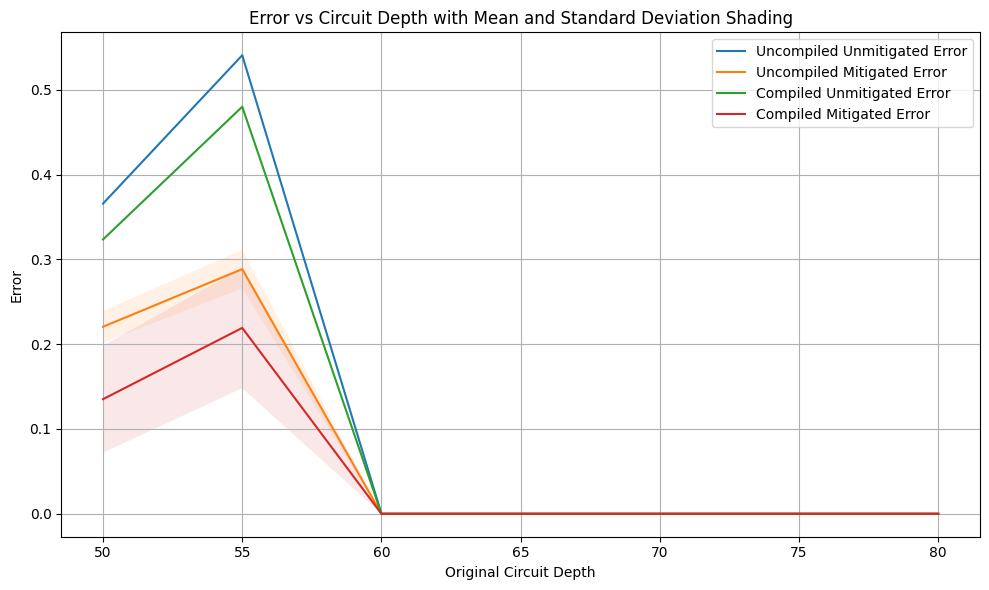

In [ ]:
# Ensure the means and stds are numeric arrays for proper math operations
# Recalculate grouped statistics with explicit numeric conversion
grouped = df.groupby("depth").agg(["mean", "std"])
for col in grouped.columns:
    grouped[col] = pd.to_numeric(grouped[col], errors="coerce")

colors = {
    "uncompiled_unmitigated_error": "blue",
    "uncompiled_mitigated_error": "green",
    "compiled_unmitigated_error": "red",
    "compiled_mitigated_error": "purple",
}

# Plot with shaded std dev regions
plt.figure(figsize=(10, 6))

for error in error_types:
    means = grouped[error]["mean"].values.astype(float)
    stds = grouped[error]["std"].values.astype(float)
    depths = grouped.index.values.astype(float)
    # color = colors[error]

    plt.plot(depths, means, label=error.replace("_", " ").title())
    plt.fill_between(depths, means - stds, means + stds, alpha=0.1)

plt.xlabel("Original Circuit Depth")
plt.ylabel("Error")
plt.title("Error vs Circuit Depth with Mean and Standard Deviation Shading")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

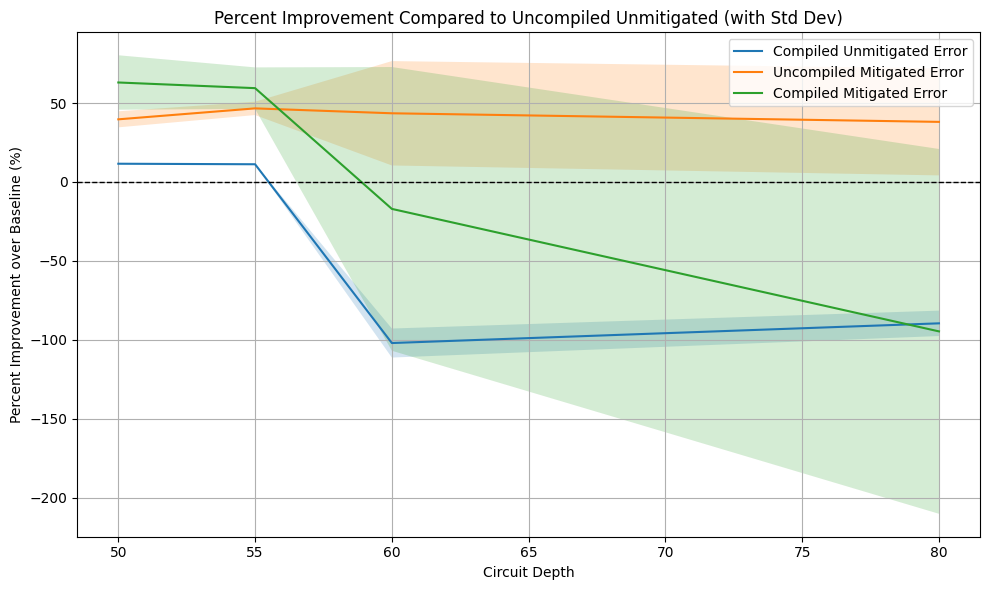

In [ ]:
import numpy as np

# Compute combined standard deviation for the difference (approximation)
# std_diff = sqrt(std_baseline^2 + std_method^2)
percent_improvements_with_std = []

summary = df.groupby("depth").agg(["mean", "std"])
baseline_mean = summary[
    ("uncompiled_unmitigated_error", "mean")
].values.astype(float)
baseline_std = summary[("uncompiled_unmitigated_error", "std")].values.astype(
    float
)

method_order = [
    "uncompiled_unmitigated_error",  # baseline
    "compiled_unmitigated_error",
    "uncompiled_mitigated_error",
    "compiled_mitigated_error",
]


for method in method_order[1:]:
    method_mean = summary[(method, "mean")].values.astype(float)
    method_std = summary[(method, "std")].values.astype(float)

    improvement = 100 * (baseline_mean - method_mean) / baseline_mean
    std_improvement = 100 * np.sqrt(
        (baseline_std / baseline_mean) ** 2 + (method_std / baseline_mean) ** 2
    )

    percent_improvements_with_std.append(
        (method, improvement, std_improvement)
    )

# Plot with properly computed std deviations
plt.figure(figsize=(10, 6))

depths = summary.index.values.astype(float)

for method, improvement, std in percent_improvements_with_std:
    label = method.replace("_", " ").title()

    plt.plot(depths, improvement, label=label)
    plt.fill_between(depths, improvement - std, improvement + std, alpha=0.2)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Circuit Depth")
plt.ylabel("Percent Improvement over Baseline (%)")
plt.title(
    "Percent Improvement Compared to Uncompiled Unmitigated (with Std Dev)"
)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
test = get_circuit(depth=20)

execute(test, noise_level=0.0)

0.0

In [79]:
test

┌──┐       ┌──┐           ┌──┐
0: ───────────X───Z───X───────@─────────────@────X─────@────X───X─────X────@───H───────────────
              │               │             │    │     │        │     │    │
1: ───X───X───@───────────H───┼───Z───X────Y┼────@────H┼────X───@────H┼────X───@───Z───X───Z───
                              │       │     │          │              │        │       │
2: ───Z───H───────Y───Y───Y───X───H───@─────X────Y─────X────────Y─────@────────X───Z───@───Z───
                                          └──┘       └──┘           └──┘

In [83]:
simulator = cirq.Simulator()

simulator.simulate(noisy_circuit)

measurements: (no measurements)

qubits: (cirq.NamedQubit('1'), cirq.NamedQubit('0'), cirq.NamedQubit('2'))
output vector: 0.5|001⟩ + 0.5|010⟩ + 0.5|101⟩ + 0.5|110⟩

phase:
output vector: |⟩

In [ ]:
cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[
    0, 0
]

(0.024247011+0j)

In [ ]:
noisy_circuit = cirq.Circuit()
for op in test.all_operations():
    noisy_circuit.append(op)
    if len(op.qubits) == 2:
        noisy_circuit.append(cirq.depolarize(p=0.02, n_qubits=2)(*op.qubits))

print(noisy_circuit)

rho = (
    cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix
)

print(rho)
rho[0, 0].real

                                                                    ┌──┐                           ┌──┐   ┌────────┐                     ┌──┐
0: ───────────X───#2────────Z───X───@───D(0.02)───────────────────────@────D(0.02)───X───#2──────────@─────D(0.02)─────X───X───#2──────────X────#2────────@───D(0.02)───H───────────────────────────────────
              │   │                 │   │                             │    │         │   │           │     │               │   │           │    │         │   │
1: ───X───X───@───D(0.02)───H───Z───┼───┼─────────────X───#2─────────Y┼────┼─────────@───D(0.02)────H┼─────┼──────X────────@───D(0.02)────H┼────┼─────────X───#2────────@───D(0.02)───Z───X───#2────────Z───
                                    │   │             │   │           │    │                         │     │                               │    │                       │   │             │   │
2: ───Z───H───Y───Y─────────Y───────X───#2────────H───@───D(0.02)─────X────#2────────Y──────────

0.024247011